In [2]:
%pylab inline
rcParams['figure.figsize'] = (15, 9)
import pycwt
import exdir
import exdir.plugins.quantities

Populating the interactive namespace from numpy and matplotlib


In [8]:
exdir_file = exdir.File('/home/mikkel/expipe/septum-mec/actions/1809-200918-01/data/main.exdir',
                       plugins=exdir.plugins.quantities)
lfp_group = exdir_file['processing/electrophysiology/channel_group_0/LFP/LFP_timeseries_0']
data = lfp_group['data'].data

sampling_frequency = lfp_group['data'].attrs['sample_rate'].magnitude
sampling_period = 1 / sampling_frequency

times = arange(0, sampling_period * len(data), sampling_period)

mask = (10 < times) & (times < 20) # seconds
data = data[mask]
times = times[mask]
duration = sampling_period * len(data)

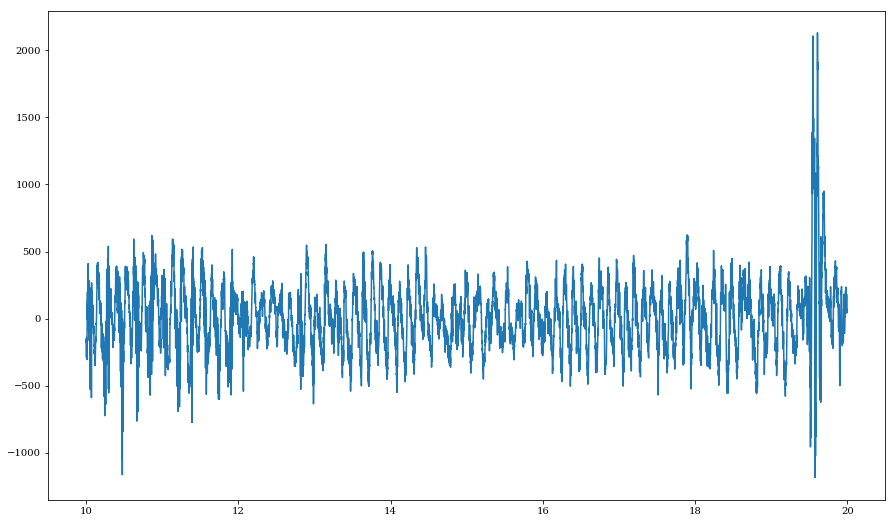

In [9]:
plot(times, data)

In [10]:
def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = nan

In [20]:
mother = pycwt.Morlet(12)
freqs = arange(1, 30)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data, sampling_period, freqs=freqs, wavelet=mother)

power = (numpy.abs(wave)) ** 2
power /= scales[:, None] #rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)

In [21]:
mask_coi(power, freqs, coi)

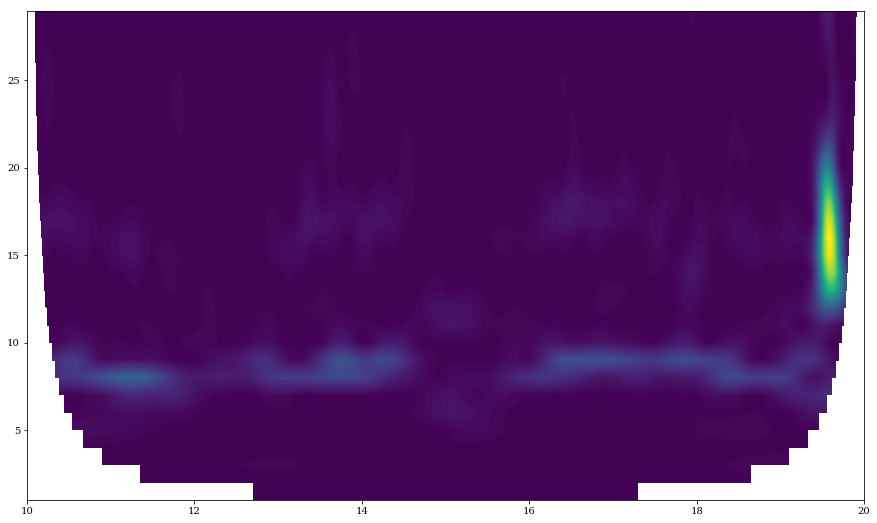

In [22]:
contourf(times, freqs, power, levels=100)

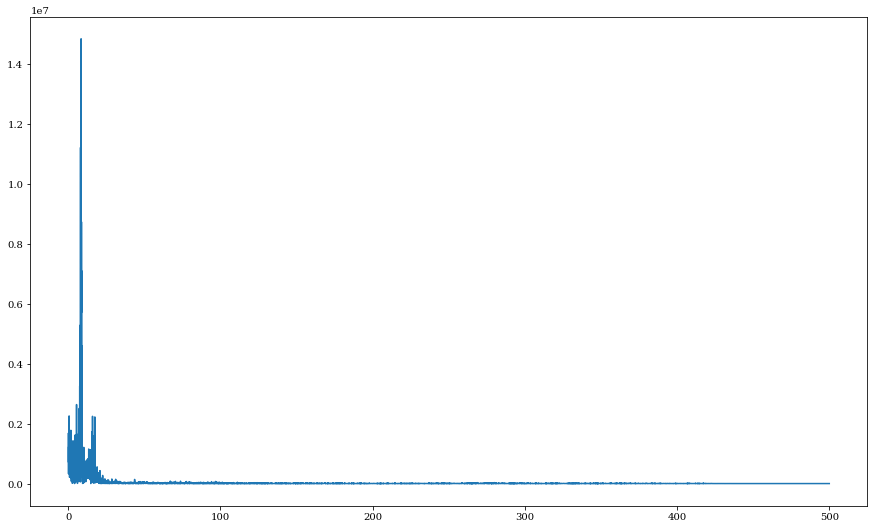

In [71]:
fft_power = numpy.abs(fft) ** 2
plot(fftfreqs, fft_power)

In [ ]:
N = data.size
std = data.std()  # Standard deviation
var = std ** 2  # Variance
data_norm = data / std  # Normalized dataset
dj = np.log2(scales[1] / scales[0])


alpha, _, _ = pycwt.ar1(data)  # Lag-1 autocorrelation for red noise
signif, fft_theor = pycwt.significance(1.0, sampling_period, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = pycwt.significance(var, sampling_period, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= .01) & (period < .02))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * sampling_period / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = pycwt.significance(var, sampling_period, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)